In [1]:
from analyze_partition_agg import *
from analyze_synthgraph import *

### Results Per-Fraud Detector Subsample-and-Aggregate

In [2]:
res_bias = analyze_pda_validation_results_oneshot(stat='aucs', eps=1000., n_noise_draws=50)

In [3]:
# fixing sub_rate, increasing k increases the bias
stats = [c for c in res_bias.columns if 'bias' in c]
df = res_bias.melt(id_vars=['dataset', 'sub_rate', 'k', 'method', 'eps'], value_vars=stats, var_name='algo', value_name='bias')
df['algo'] = ['_'.join(a.split('_')[1:]) for a in df['algo']]
df = df[~df.algo.isin(['agg1', 'agg2', 'agg_max', 'random'])]
df['algo'] = df['algo'].map(ALGORITHM_NAMES)
df.head()

,dataset,sub_rate,k,method,eps,algo,bias
0,amazon_sbm,0.05,20,laplace,1000.0,Clustering Coeff,-0.419020
1,amazon_sbm,0.05,50,laplace,1000.0,Clustering Coeff,-0.423009
2,amazon_sbm,0.05,100,laplace,1000.0,Clustering Coeff,-0.423363
3,amazon_sbm,0.05,200,laplace,1000.0,Clustering Coeff,-0.423422
4,amazon_sbm,0.10,10,laplace,1000.0,Clustering Coeff,-0.403569


In [4]:
def plot_bias_vs_param(plot, datasets, fixed_param_name, fixed_param_value):
    plot = df[(df[fixed_param_name] == fixed_param_value) & (df['dataset'].isin(datasets))].copy()
    plot['abs_bias'] = plot['bias'].abs()

    if fixed_param_name == 'k':
        x_label = 'Fraud Subsample Rate'
        param_name = 'sub_rate'
    if fixed_param_name == 'sub_rate':
        x_label = 'Number of Partitions'
        param_name = 'k'

    markers = ['o', 's', 'v', 'D', '<', 'd', '>']

    g = sns.relplot(data=plot, x=param_name, y='bias', col='dataset', kind='line', col_order=datasets,
                    hue='algo', style='algo', markers=markers, dashes=False, lw=3, markersize=8)

    # add horizontal line at 0 to each subplot  
    for ax in g.axes.flat:
        ax.axhline(0, ls='--', color='black')

    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16)
        
    g.set_ylabels('Bias of AUC Score', fontsize=16)
    g.set_xlabels(x_label, fontsize=16)

    # increase fontsize of x and y tick labels
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=14)

    # move legend outside plot to the botom and split into two rows
    g.figure.legend(title='Fraud Detector', ncols=3, bbox_to_anchor=(0.5, -0.25), loc='lower center', fontsize=12, title_fontsize=14)
    g._legend.set_visible(False)

    plt.tight_layout()
    save_path=f"results/figures/bias_vs_{param_name}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)
    plt.show()


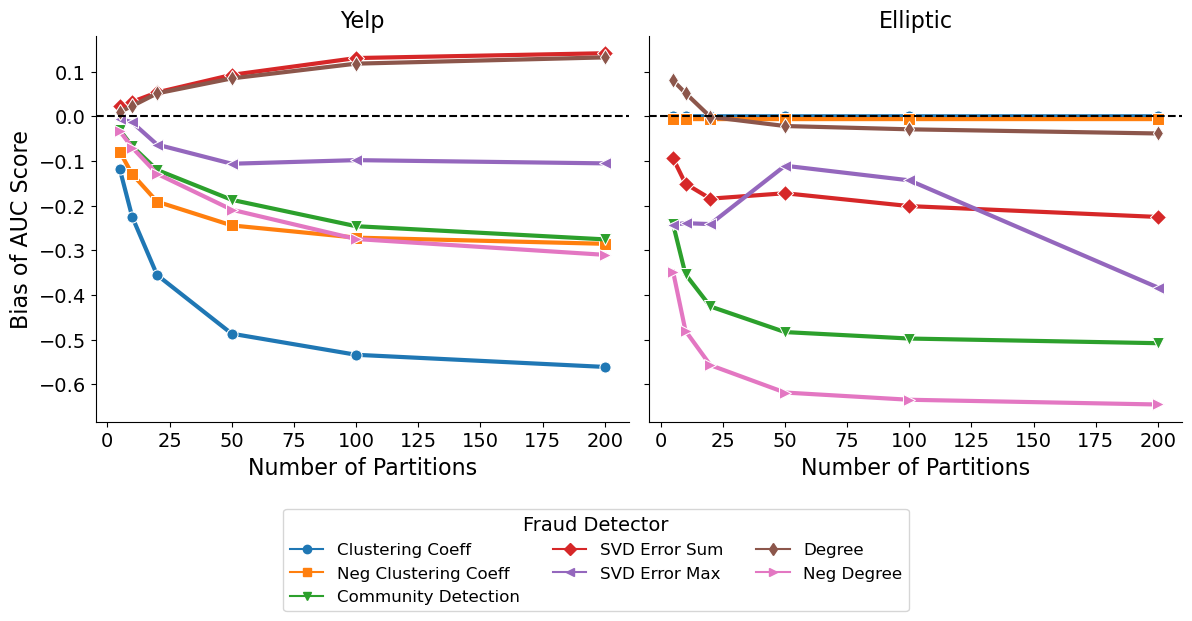

In [5]:
SUB_RATE = 0.25
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

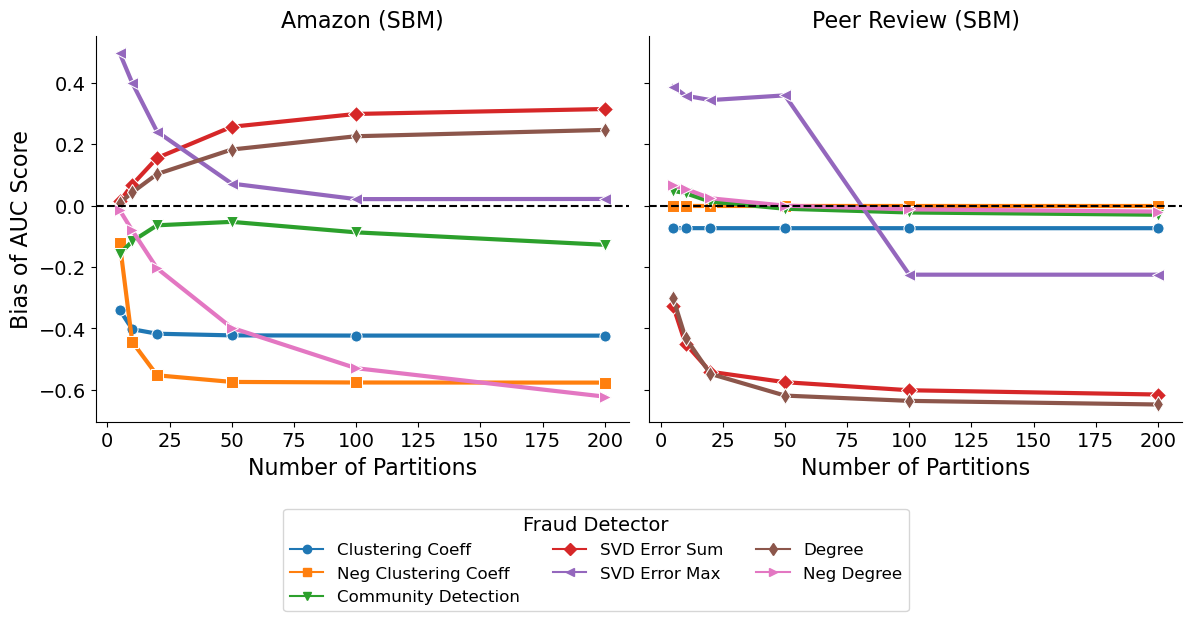

In [6]:
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

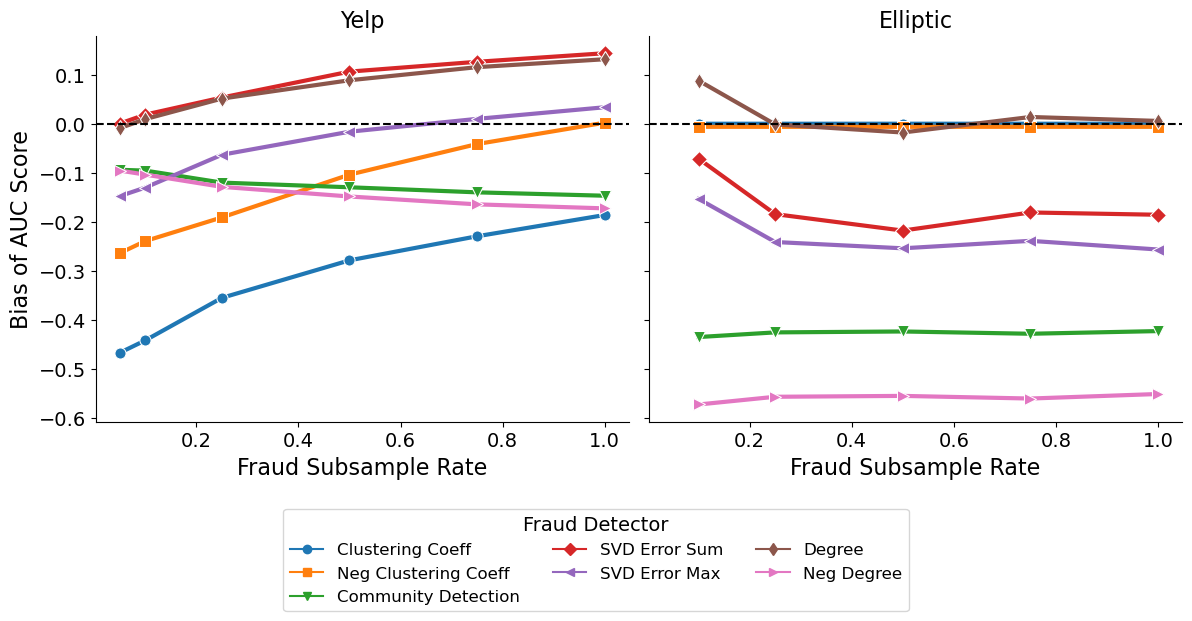

In [7]:
K = 20
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'k', K)

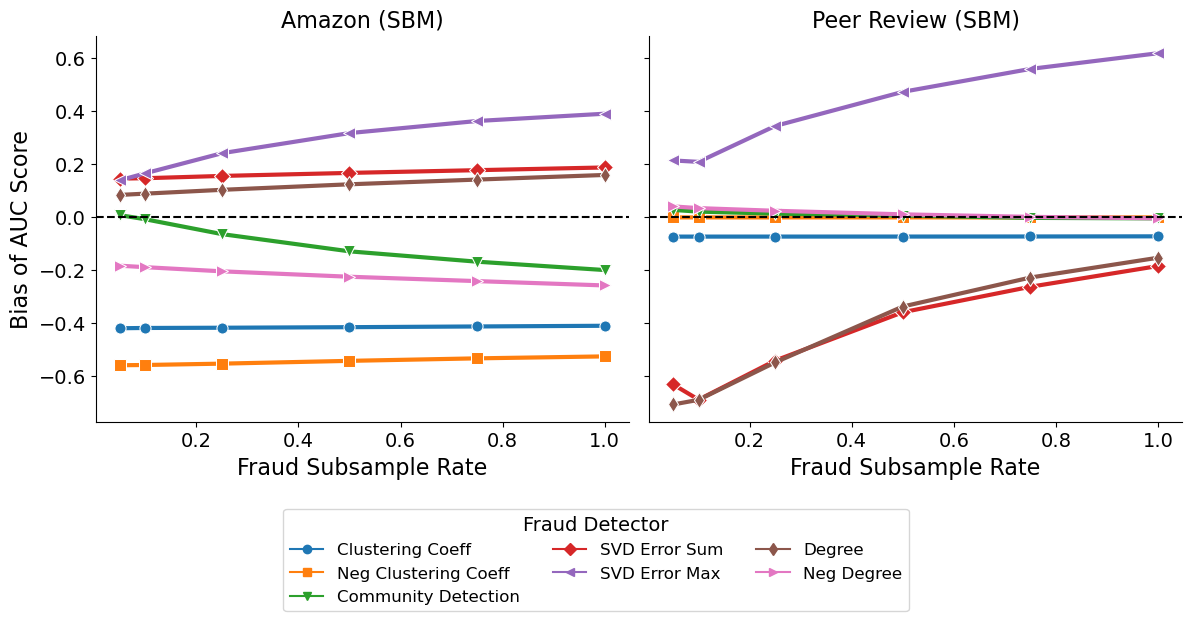

In [8]:
K = 20
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'k', K)

## Results for Leaderboard Subsample-and-Aggregate 

In [270]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [10]:
random_baselines = get_leaderboard_baselines(split='val')

=== Kendall Tau Baseline for Validation Sets ===
Test vs. Val yelp: 0.0033
Random: 5.2972
Test vs. Val elliptic: 0.021
Random: 5.8816
Test vs. Val amazon_sbm: 0.5359
Random: 8.1541
Test vs. Val peer_review_sbm: 1.1187
Random: 8.5293


In [40]:
def add_hatches(g, n_bars=2, plot_type='catplot'):
    # hatches for each bar
    hatches = ['//', '..', 'xx', '++', 'oo', 'O', '||', '\\\\', '|||', '---', '///', '+++']
    hatches = hatches[:n_bars]

    # iterate through each subplot / Facet
    iter_ax = g.axes.flat if plot_type == 'catplot' else [g.axes]
    for ax in iter_ax:
        # select the correct patches
        patches = [patch for patch in ax.patches]

        # the number of patches should be evenly divisible by the number of hatches
        h = [[hatch]*(len(patches) // n_bars) for hatch in hatches]
        h = [item for sublist in h for item in sublist]
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor('none')

    return hatches


def plot_k_vs_kendalltau(df, sub_rate, datasets, eps, random_baselines):
    df = df[df['sub_rate'] == sub_rate]

    max_eps = df.eps.max()
    df = df[df.eps.isin([max_eps, eps])]
    df['eps'] = df['eps'].astype(str)

    # get results with no noise
    g = sns.catplot(data=df, x='k', y='dist', col='dataset', kind='bar',
                     col_order=datasets,hue='eps', errorbar=("ci", 95), capsize=0.05, errwidth=1.5, palette='colorblind', hue_order=[str(max_eps), str(eps)])       
    
    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.axhline(random_baselines[datasets[i]], ls='--', color='black') # add line for random baseline
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16) # set title to just dataset name
        ax.tick_params(axis='both', which='major', labelsize=14) # increase fontsize of x and y tick labels
    
    _ = add_hatches(g)
        
    g.set_ylabels('Weighted Kendall-Tau Distance', fontsize=16)
    g.set_xlabels('Number of Partitions (k)', fontsize=16)      

    handles, _ = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()
    l = g.figure.legend(handles, ['No Noise', f'Laplace Noise ($\epsilon$={int(eps/10.) if eps >= 10. else round(eps/10., 1)})'], ncol=2, loc='lower center', 
                bbox_to_anchor=(0.5, -0.1), frameon=False, fontsize=16)

    plt.tight_layout()

    save_path=f"results/figures/kendall_tau_nonoise_vs_{eps}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)

    plt.show()

In [16]:
SUB_RATE = 0.5
EPS = 5.
DATASETS = ['yelp', 'elliptic']

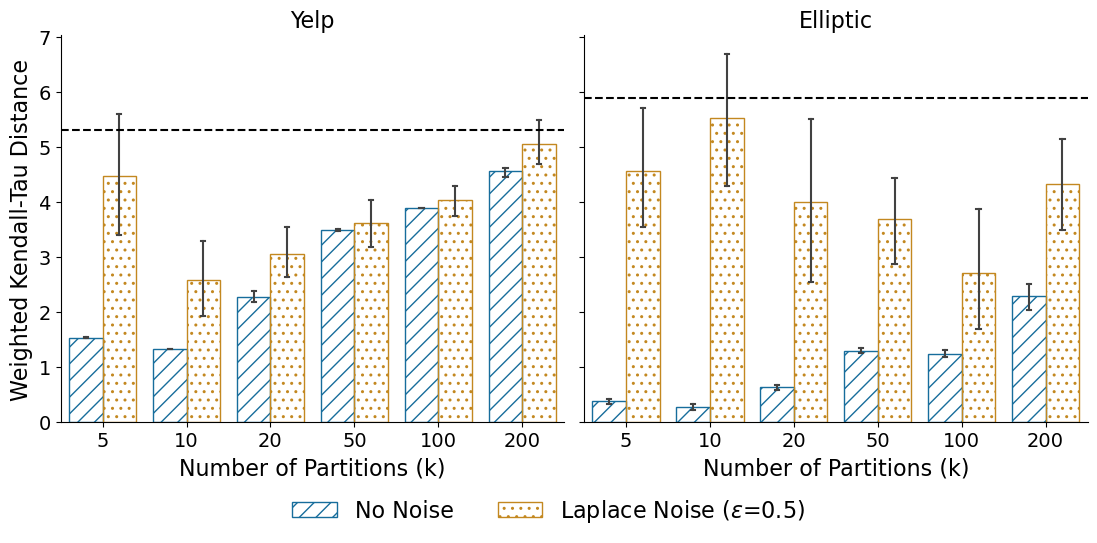

In [17]:
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, EPS, random_baselines)

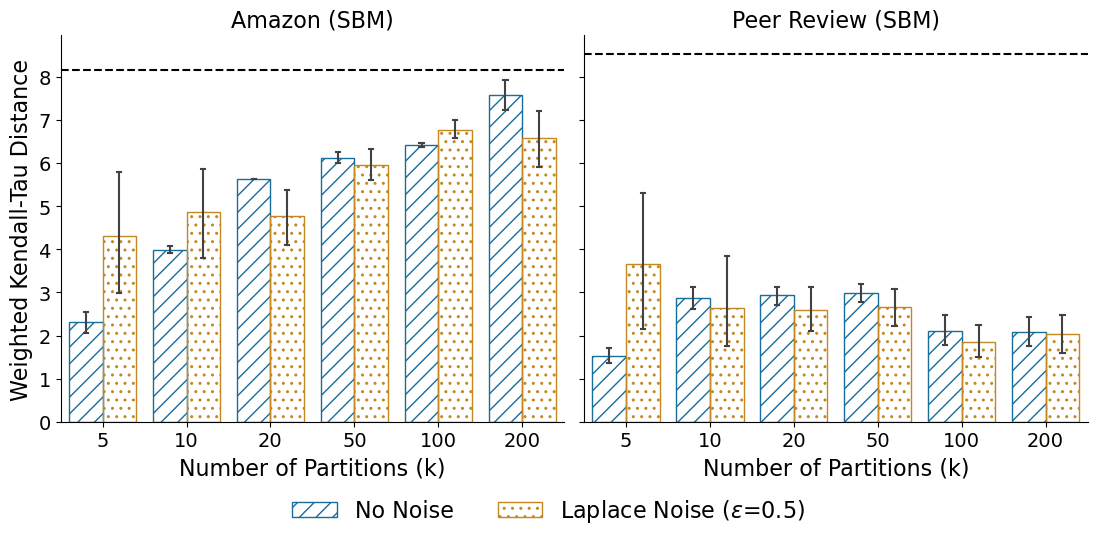

In [18]:
SUB_RATE = 0.5
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, EPS, random_baselines)

In [310]:
DATASETS = ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm']

df_agg = df.groupby(['dataset', 'k', 'sub_rate', 'eps'])['dist'].mean().reset_index()
df_plot = df_agg.groupby(['dataset', 'k', 'eps']).apply(lambda x: x[x['dist'] == x['dist'].min()])[['dist', 'sub_rate']].reset_index()
df_plot = df_plot[df_plot.dataset.isin(DATASETS)]
df_plot = df_plot[df_plot.k > 5]

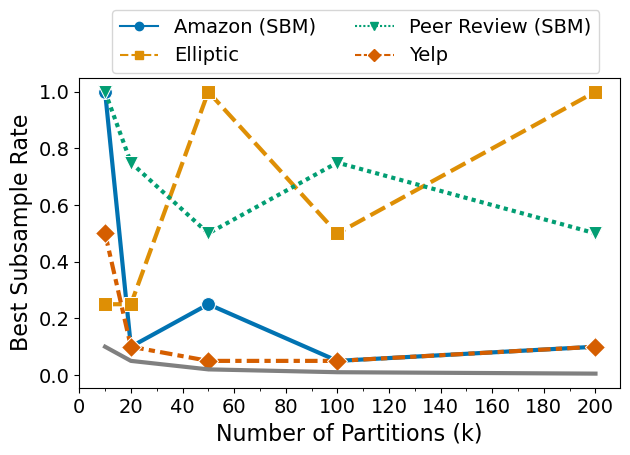

In [317]:
# Best sub_rate as a function of k
markers = ['o', 's', 'v', 'D', '<', 'd', '>']
ax = sns.lineplot(data=df_plot[df_plot.eps == 5.], x='k', y='sub_rate', hue='dataset', palette='colorblind',
              lw=3, markers=markers[:len(DATASETS)], style='dataset', markersize=10)

ax.set_xlabel('Number of Partitions (k)', fontsize=16)
ax.set_ylabel('Best Subsample Rate', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[DATASET_NAMES[l] for l in labels], title_fontsize=16, fontsize=14, loc='upper right', ncols=2, bbox_to_anchor=(0.98, 1.25))

xs = df_plot.k.unique()
ys = [1./k for k in xs]
ax.plot(xs, ys, '-', label='1/k', lw=3, color='grey')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(0,210, 20))
# minor ticks every 10 on x axis
ax.set_xticks(range(0,210, 10), minor=True)
plt.tight_layout()

plt.savefig('results/figures/best_subrate_vs_k.pdf')

## Params for Partition-Aggregate

In [20]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [41]:
# grid search over all k,sub_rate combos to see best performing in terms of kendall-tau
def get_best_params(df, datasets, eps, pooled=False, top=5):
    df = df[df['dataset'].isin(datasets) & (df['eps'] == eps)]
    if pooled:
        df = df.groupby(['sub_rate', 'k'])['dist'].mean().reset_index()
        return df.sort_values(by='dist', ascending=True).head(top)
    df = df.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()
    best = [df[df['dataset'] == dataset].sort_values(by='dist', ascending=True).head(top) for dataset in datasets]
    return pd.concat(best)

def get_values(df, datasets, eps, sub_rate, k):
    df = df[(df['dataset'].isin(datasets)) & (df['eps'] == eps) & (df['sub_rate'] == sub_rate) & (df['k'] == k)]
    df = df.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()
    return df

In [93]:
def plot_best_pooled_vs_best_unpooled(df, datasets, eps, ax):
    best_pooled = get_best_params(df, datasets, eps, pooled=True, top=1)
    best_unpooled = get_best_params(df, datasets, eps, pooled=False, top=1)

    best_pooled_subrate = best_pooled['sub_rate'].values[0]
    best_pooled_k = best_pooled['k'].values[0]

    best_pooled_by_dataset = df[(df['dataset'].isin(datasets)) & (df['eps'] == eps) & (df['sub_rate'] == best_pooled_subrate) & (df['k'] == best_pooled_k)]
    best_pooled_by_dataset = best_pooled_by_dataset.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()

    best_unpooled['kind'] = 'Per Dataset'
    best_pooled_by_dataset['kind'] = 'Averaged'  

    g = sns.barplot(data=pd.concat([best_unpooled, best_pooled_by_dataset]), x='dataset', y='dist', hue='kind', palette='colorblind', ax=ax)
    _ = add_hatches(g, n_bars=2, plot_type='barplot')  

    g.legend(title='', fontsize=13)
    g.set_ylabel('Weighted Kendall-Tau Distance', fontsize=16)
    g.set_xlabel('', fontsize=16)

    def reformatter(x):
        if 'sbm' in x:
            return '\n'.join(DATASET_NAMES[x].split(' '))
        return DATASET_NAMES[x]
    
    g.set_xticklabels([reformatter(d) for d in datasets], fontsize=14)
    g.axes.tick_params(axis='both', which='major', labelsize=14) # increase fontsize of x and y tick labels
    g.set_title(f'$\epsilon$={int(eps/10.) if eps >= 10. else round(eps/10., 1)} per fraud detector', fontsize=16)

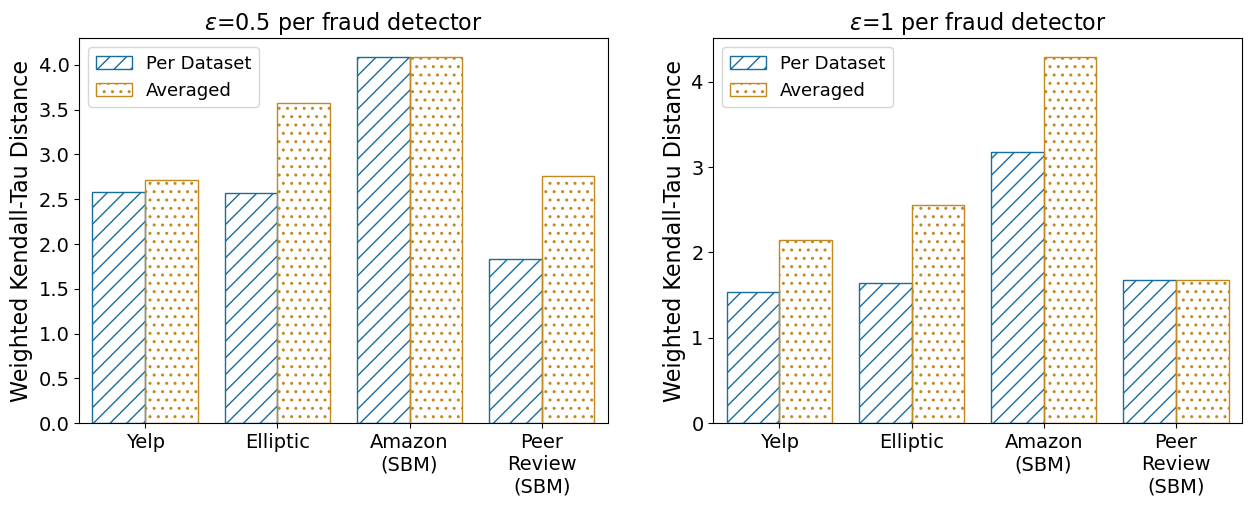

In [97]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
for i, eps in enumerate([5., 10.]):
    plot_best_pooled_vs_best_unpooled(df, ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm'], eps, axes.ravel()[i])

plt.tight_layout()
plt.savefig('results/figures/best_pooled_vs_best_unpooled.pdf')

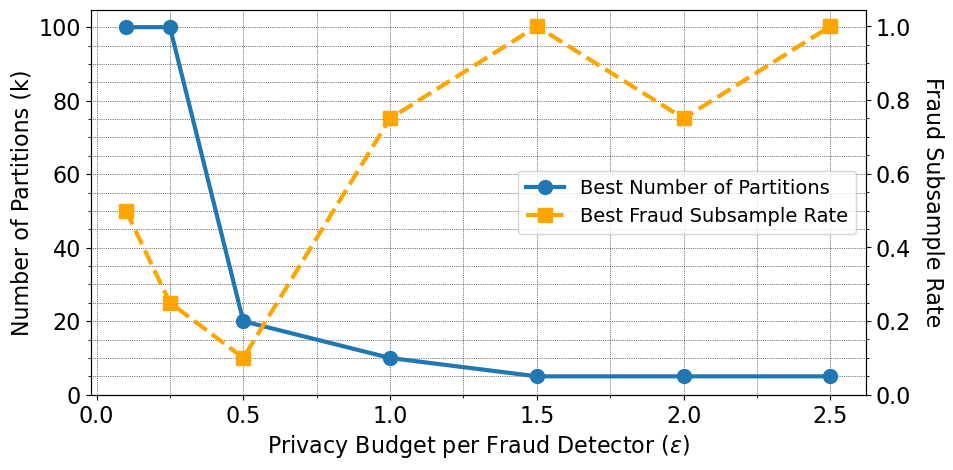

In [164]:
# setup ax for plot
fig, ax = plt.subplots(figsize=(10, 5))

best_k_avg = [get_best_params(df, DATASETS, eps, pooled=True, top=1)['k'].values[0] for eps in df.eps.unique()][:-1]
ax.plot([e/10. for e in df.eps.unique()[:-1]], best_k_avg, marker='o', markersize=10, lw=3, label='Best Number of Partitions')
plt.xlabel('Privacy Budget per Fraud Detector ($\epsilon$)', fontsize=16)
plt.ylabel('Number of Partitions (k)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 110, 20), fontsize=16)
# add minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.25))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


best_subrate_avg = [get_best_params(df, DATASETS, eps, pooled=True, top=1)['sub_rate'].values[0] for eps in df.eps.unique()][:-1]
# plot with second y-axis
ax2 = plt.twinx()
ax2.plot([e/10. for e in df.eps.unique()[:-1]], best_subrate_avg, marker='s', markersize=10, lw=3, color='orange', linestyle='--', label='Best Fraud Subsample Rate')
# flip ylabel text orientation on right side
plt.ylabel('Fraud Subsample Rate', fontsize=16, rotation=270, labelpad=24)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=16)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=14)

# ax.legend(title='', fontsize=16)

# # add grid for minor ticks
plt.savefig('results/figures/best_k_vs_eps.pdf')
plt.show()

In [143]:
for eps in df.eps.unique()[:-1]:
    d = get_best_params(df, ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm'], eps, pooled=True, top=1)
    print(f'eps={eps}, k={d.k.values[0]}, sub_rate={d.sub_rate.values[0]}')

eps=1.0, k=200, sub_rate=0.1
eps=2.5, k=50, sub_rate=0.25
eps=5.0, k=20, sub_rate=0.1
eps=10.0, k=10, sub_rate=0.75
eps=15.0, k=5, sub_rate=0.75
eps=20.0, k=5, sub_rate=0.75
eps=25.0, k=5, sub_rate=0.75


## Analyze Noise to Sufficient Statistics of Graph Models for Different Thresholds at varying epsilon

In [165]:
df = pd.read_csv('results/synthetic_param_estimation.csv', sep=',')
list_cols = ['sbm_params', 'sbm_params_err', 'degree_seq', 'degree_seq_err']
for c in list_cols:
    df[c] = df[c].replace(np.nan, '[]').apply(lambda x: np.array(ast.literal_eval(x)))

In [166]:
df.head()

,eps,deg_cutoff_rate,iters,non_private,iter,dataset,synthetic_algo,sbm_params,sbm_params_err,n_edges,n_triangles,degree_seq,n_edges_flipped,degree_seq_err,n_triangles_err,n_edges_err
0,1.0,1.0,10,False,0,yelp,sbm_dp,"[0.009882529969243369, 0.0041324636377779835]","[-0.0004570713395833006, 8.091149057462554e-06]",NaN,NaN,[],NaN,[],NaN,NaN
1,1.0,1.0,10,False,0,yelp,attr_graph_simp,"[0.009882529969243369, 0.0041324636377779835]","[5.572154727083098e-05, 8.41450851790564e-05]",NaN,NaN,"[0, 58, 63, 22, 18, 25, 37, 48, 39, 53, 58, 56...",NaN,"[254, -58, -63, -22, -18, -25, -37, -48, -39, ...",-27006702.0,NaN
2,1.0,1.0,10,False,0,yelp,attr_graph,"[0.009882529969243369, 0.0041324636377779835]","[0.0039913357928858025, -0.005267667762454983]",NaN,27006702.0,"[0, 58, 63, 22, 18, 25, 37, 48, 39, 53, 58, 56...",NaN,"[7922, -58, -63, -22, -18, -25, -37, -48, -39,...",-26859246.0,NaN
3,1.0,1.0,10,False,0,yelp,topmfilter,[],[],548207.0,NaN,[],1317412.0,[],NaN,269167.0
4,1.0,1.0,10,False,0,elliptic,sbm_dp,"[0.0002958047432429712, 0.00014964011552216918]","[-0.02209807860052193, 0.0006579051733237419]",NaN,NaN,[],NaN,[],NaN,NaN


In [182]:
rel_err_sbm, rel_err_attr, rel_err_topm = analyze_param_error(df)

In [252]:
DATASETS = ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm']

# Best truncation parameter as a function of eps for each dataset (separate line), one plot for each parameter
def plot_best_truncation_param(rel_err_sbm, rel_err_attr, rel_err_topm, datasets, param_name, ax=None):
    if param_name == 'rel_err_sbm':
        df = rel_err_sbm
        title = 'SBM Edge Probabilities'
    if param_name == 'rel_err_degree_seq':
        title = 'Degree Sequence'
        datasets.remove('peer_review_sbm')
        df = rel_err_attr
    if param_name == 'rel_err_ntriangles':
        df = rel_err_attr
        datasets.remove('peer_review_sbm')
        title = 'Num Triangles'
    if param_name == 'prop_edges_flipped':
        df = rel_err_topm
        title = 'Adjacency Matrix'

    best_params = []
    for dataset in datasets:
        d = df[df['dataset'] == dataset]
        best_param = d.groupby('eps')[param_name].idxmin().apply(lambda x: d.loc[x, 'deg_cutoff_rate']).reset_index()
        best_param['dataset'] = dataset
        best_params.append(best_param)
    best_params = pd.concat(best_params)

    markers = ['o', 's', 'v', 'D', '<', 'd', '>']
    g = sns.lineplot(data=best_params, x='eps', y=param_name, hue='dataset', hue_order=datasets, lw=3, markersize=10, style='dataset',
                      markers=markers[:len(datasets)], palette='colorblind', ax=ax)

    g.set_xlabel('$\epsilon$', fontsize=16)
    g.set_ylabel('Best Truncation Parameter', fontsize=16)
    g.legend(title='Dataset', fontsize=14, title_fontsize=14, ncol=2)

    # rename legend labels
    handles, labels = g.get_legend_handles_labels()
    labels = [DATASET_NAMES[l] for l in labels]
    g.legend(handles, labels, title='', fontsize=13, title_fontsize=14, ncol=2)

    g.set_yticks(np.arange(0, 1.1, 0.25))
    g.set_xticks([1,2,5,10])
    g.tick_params(axis='both', which='major', labelsize=14)
    g.set_title(title, fontsize=14)

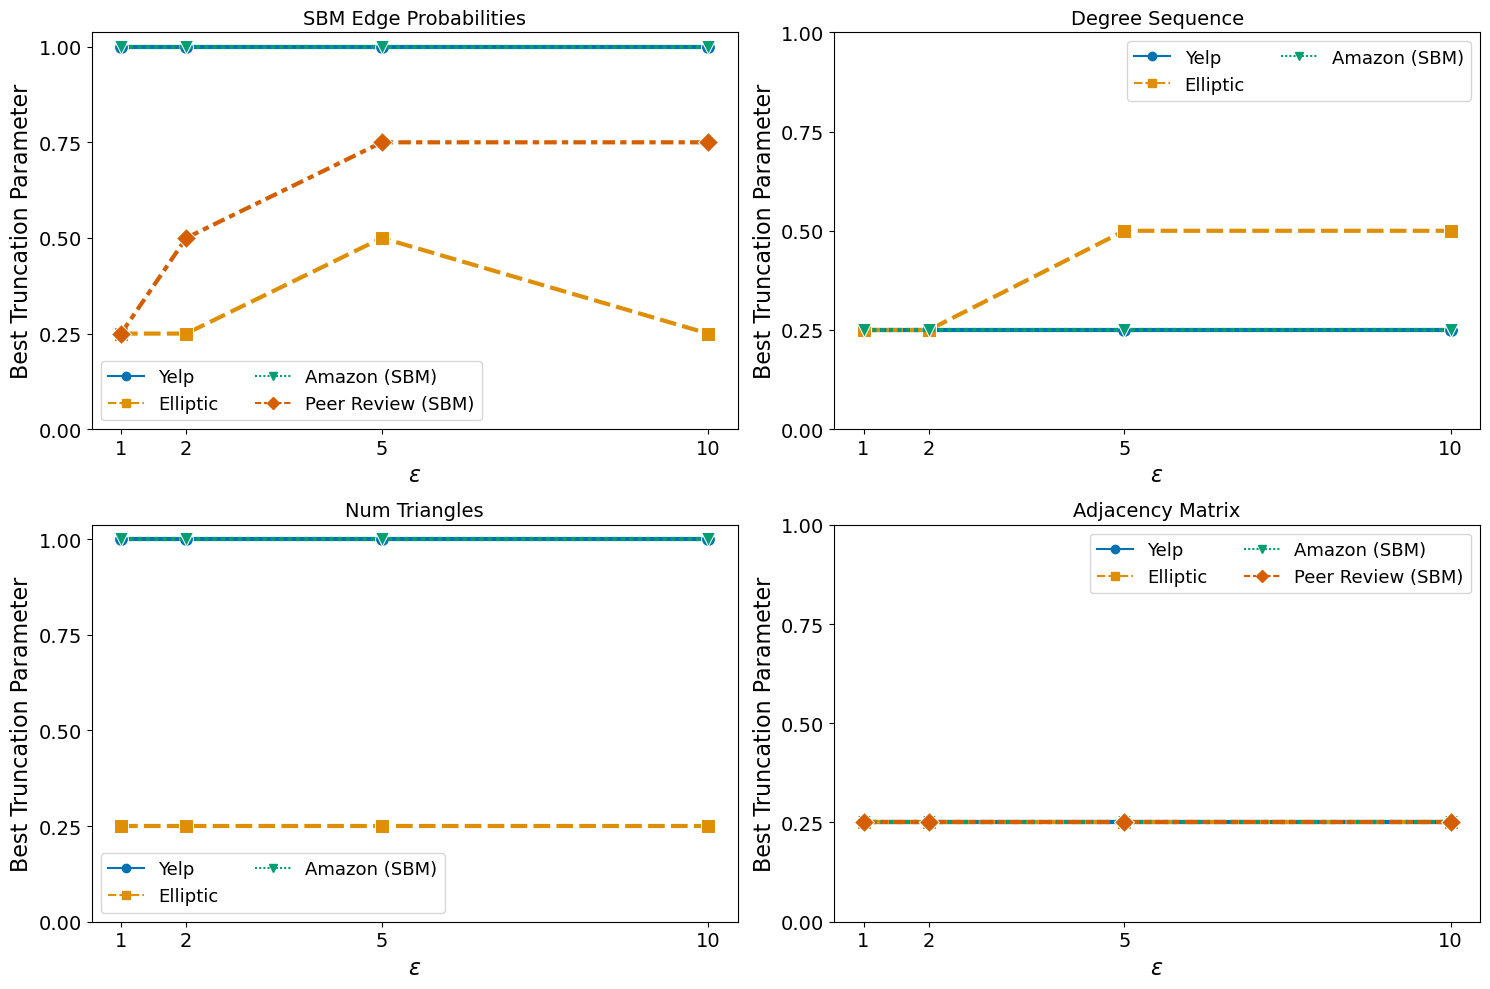

In [253]:
params = ['rel_err_sbm', 'rel_err_degree_seq', 'rel_err_ntriangles', 'prop_edges_flipped']
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for i, param in enumerate(params):
    plot_best_truncation_param(rel_err_sbm, rel_err_attr, rel_err_topm, DATASETS.copy(), param, ax=axes.ravel()[i])
    plt.tight_layout()
    plt.savefig(f'results/figures/best_truncation_param_{param}.pdf')

In [264]:
def get_param_err_table(param_name, rel_err_sbm, rel_err_attr, rel_err_topm, deg_cutoff_rate=1., eps=[1., 2., 5.]):
    if param_name == 'rel_err_sbm':
        df = rel_err_sbm
        title = 'SBM Edge Probabilities'
    if param_name == 'rel_err_degree_seq':
        title = 'Degree Sequence'
        df = rel_err_attr
    if param_name == 'rel_err_ntriangles':
        df = rel_err_attr
        title = 'Num Triangles'
    if param_name == 'prop_edges_flipped':
        df = rel_err_topm
        title = 'Adjacency Matrix'

    df = df[df['deg_cutoff_rate'] == deg_cutoff_rate]
    df = df[df['eps'].isin(eps)]
    # make each eps a column per row
    df = df.pivot(index='dataset', columns='eps', values=param_name).reset_index()
    return df 

In [265]:
### MAKE TABLE OF ERRORS ### 
get_param_err_table('rel_err_sbm', rel_err_sbm, rel_err_attr, rel_err_topm, deg_cutoff_rate=1., eps=[1., 2., 5.])

eps,dataset,1.0,2.0,5.0
0,amazon_sbm,0.026,0.009,0.001
1,elliptic,2202.733,1197.858,204.578
2,peer_review_sbm,10.901,5.040,0.307
3,yelp,0.019,0.008,0.001


In [266]:
get_param_err_table('rel_err_degree_seq', rel_err_sbm, rel_err_attr, rel_err_topm, deg_cutoff_rate=1., eps=[1., 2., 5.])

eps,dataset,1.0,2.0,5.0
0,amazon_sbm,2.0,1.997,1.965
1,elliptic,2.0,1.999,1.998
2,yelp,2.0,1.997,1.983


In [269]:
get_param_err_table('prop_edges_flipped', rel_err_sbm, rel_err_attr, rel_err_topm, deg_cutoff_rate=1., eps=[1., 2., 5.])

eps,dataset,1.0,2.0,5.0
0,amazon_sbm,1.938291,1.951539,1.941969
1,elliptic,3.241279,2.057313,2.088310
2,peer_review_sbm,1.897630,1.910004,1.958869
3,yelp,1.999697,1.927893,1.932796


In [ ]:
get_param_err_table('rel_err_ntriangles', rel_err_sbm, rel_err_attr, rel_err_topm, deg_cutoff_rate=1., eps=[1., 2., 5.])

## Analyze Graphs Generated with No Noise to Sufficient Statistics and With Noise

In [2]:
def load_nonprivate_results():
    df = pd.read_csv('synthetic_graphs/aucs_nonpriv.csv')
    true_aucs = generate_nonprivate_leaderboard(split='val')
    algos = true_aucs.algo.unique()
    df = df.melt(id_vars=['dataset', 'synthetic_algo', 'iter'], value_vars=algos, var_name='algo', value_name='auc')
    df = df.join(true_aucs.set_index(['dataset', 'algo']), on=['dataset', 'algo'], rsuffix='_true')
    df['auc_err'] = (df['auc'] - df['auc_true']).abs() # absolute error in auc per dataset

    return df 

In [3]:
df = load_nonprivate_results()

In [90]:
def plot_nonprivate(df, datasets):
    df = df[df['dataset'].isin(datasets)]
    df = df[~df.algo.isin(['agg1', 'agg2', 'agg_max', 'random'])]
    df = df[~df.synthetic_algo.isin(['topmfilter', 'attr_graph_simp'])] 
    g = sns.catplot(data=df, x='algo', y='auc_err', hue='synthetic_algo', col='dataset', kind='bar',
                         col_order=datasets, palette='colorblind', sharey=True, errorbar=('ci', 95), errwidth=1.5, capsize=0.05, order=list(ALGORITHM_NAMES.keys())[1:-3])
    g.set_ylabels('Absolute Error in AUC', fontsize=16)
    g.set_xlabels('Fraud Detector', fontsize=16)

    algo_key = [f'{i+1}: {ALGORITHM_NAMES[t.get_text()]}' for i,t in enumerate(g.axes.flat[0].get_xticklabels())]

    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16)
         # get xticks and print them 
        x_ticks = ax.get_xticks()
         # add grid for y ticks
        ax.grid(axis='y', linestyle='-', linewidth='0.75', color='grey', alpha=0.5)
        ax.grid(axis='y', linestyle='-', linewidth='0.5', color='grey', alpha=0.5, which='minor')
    
    # add minor ticks on y-axis
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))

    g.set_xticklabels(1+np.arange(len(x_ticks)), fontsize=14)
    # increase fontsize of x and y tick labels
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

    add_hatches(g, n_bars=2, plot_type='catplot')

    handles, _ = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()
    l = g.figure.legend(handles, ['SBM', 'AGM'], title='', ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.1), frameon=True, fontsize=16)

    # add key to bottom of figure for algo names
    plt.figtext(0.5, -0.15, ', '.join(algo_key), ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.5))

    plt.savefig('results/figures/nonprivate_auc_err.pdf')
    plt.show()

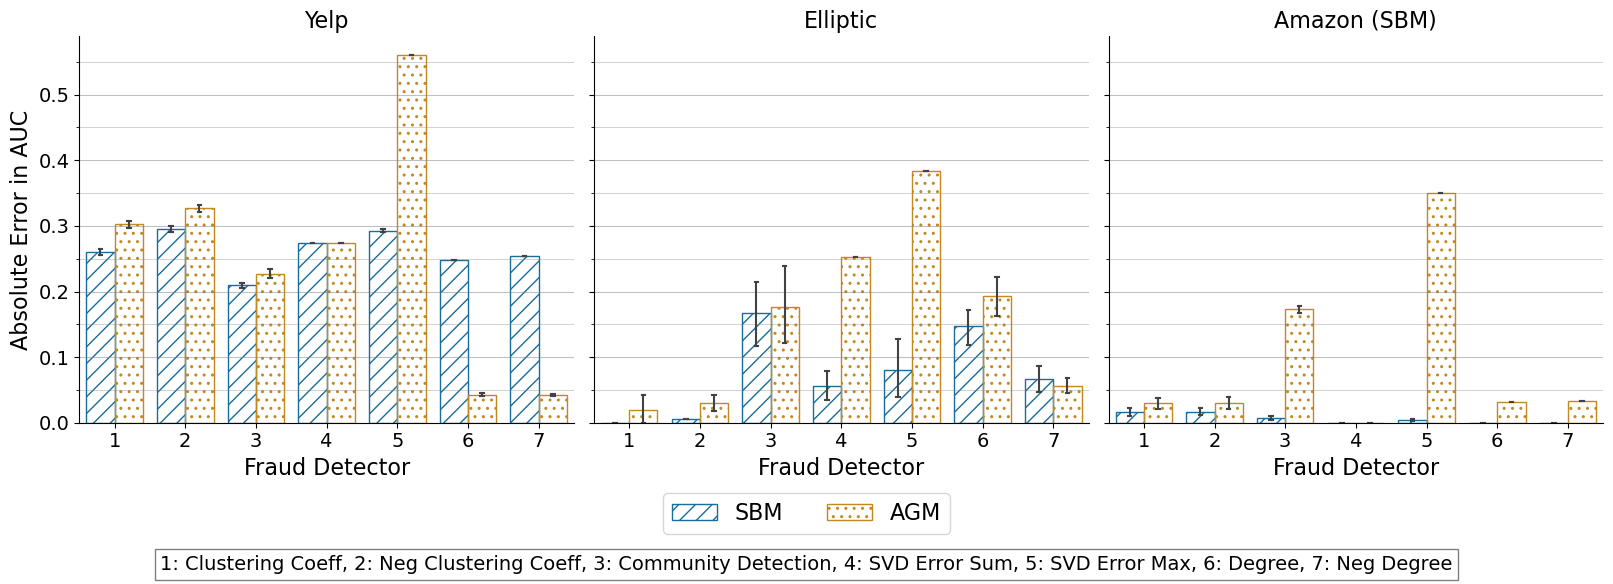

In [91]:
plot_nonprivate(df, ['yelp', 'elliptic', 'amazon_sbm'])

In [ ]:
# plot kendall tau distances for non-private results (and add private for eps = 5 eventually)

,dataset,algo,auc,rank
0,yelp,degree_neg,0.74560,1
1,yelp,community_detection,0.69870,2
2,yelp,agg_max,0.62496,3
3,yelp,clustering_coeff,0.62170,4
4,yelp,truncate_svd_max50,0.56090,5
5,yelp,agg1,0.41258,6
6,yelp,clustering_coeff_neg,0.34300,7
7,yelp,truncate_svd_sum10,0.27370,8
8,yelp,agg2,0.24870,9
9,yelp,degree,0.24800,10
